In [321]:
import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import math

In [322]:
subject_id = "001"
experiment_id = "001"

viewing_distance_cm = 70       # モニタまでの距離
screen_width_cm = 47.6           # モニタの横幅
screen_height_cm = 26.8          # モニタの高さ
diag_length_cm = math.sqrt(screen_width_cm**2 + screen_height_cm**2)

In [323]:
file_path = f"./PsychoData/id{subject_id}/{experiment_id}.csv"
psycho_df = pd.read_csv(file_path)  

In [324]:
exp_start_raw = psycho_df.loc[0, "expStart"]  # 例: "2024-11-25 16h50.12.937293 +0900"
exp_start_cleaned = exp_start_raw.replace("h", ":").replace(".", ":", 1).split(" +")[0]
dt_jst = datetime.strptime(exp_start_cleaned, "%Y-%m-%d %H:%M:%S.%f").replace(tzinfo=ZoneInfo("Asia/Tokyo"))
dt_utc = dt_jst.astimezone(ZoneInfo("UTC"))  # JST → UTC に変換
exp_start_epoch = dt_utc.timestamp()
print(exp_start_epoch)

1732521012.937293


In [325]:
pose_start_sorted = sorted(psycho_df["pose.started"].dropna().unique())
pose_stop_sorted = sorted(psycho_df["pose.stopped"].dropna().unique())

In [326]:
pose1_start = exp_start_epoch + pose_start_sorted[0]
pose1_stop  = exp_start_epoch + pose_stop_sorted[0]
pose2_start = exp_start_epoch + pose_start_sorted[1]
pose2_stop  = exp_start_epoch + pose_stop_sorted[1]

In [327]:
print(pose1_start,pose1_stop,pose2_start,pose2_stop)

1732521031.8261118 1732521091.8326926 1732521571.8339727 1732521631.827222


In [328]:
tobii_filepath = f"./tobiiData/aha-id{subject_id}-{experiment_id}.csv"
tobii_df = pd.read_csv(tobii_filepath)

In [329]:
tobii_df[["left_x", "left_y"]] = tobii_df["left_gaze_point_on_display_area"] \
    .str.strip("()") \
    .str.split(",", expand=True) \
    .astype(float)

tobii_df[["right_x", "right_y"]] = tobii_df["right_gaze_point_on_display_area"] \
    .str.strip("()") \
    .str.split(",", expand=True) \
    .astype(float)

In [330]:
tobii_df["validity_sum"] = (
    tobii_df["left_gaze_point_validity"] +
    tobii_df["right_gaze_point_validity"]
)

In [331]:
tobii_df["datetime"] = pd.to_datetime(
    tobii_df["realtime"],
    format="%Y/%m/%d %H:%M:%S.%f"
).dt.tz_localize("Asia/Tokyo").dt.tz_convert("UTC")
tobii_df["epoch_time"] = tobii_df["datetime"].apply(lambda x: x.timestamp())

In [332]:
# 表示形式を通常の10進数（小数）で表示
pd.set_option('display.float_format', '{:.3f}'.format)

In [333]:
processed_df = tobii_df[[
    "left_x", "left_y",
    "right_x", "right_y",
    "left_gaze_point_validity", "right_gaze_point_validity", "validity_sum",
    "realtime", "epoch_time"
]]

In [334]:
processed_df["mean_x"] = (processed_df["left_x"] + processed_df["right_x"]) / 2
processed_df["mean_y"] = (processed_df["left_y"] + processed_df["right_y"]) / 2


C:\Users\hisao\AppData\Local\Temp\ipykernel_6412\2290656008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df["mean_x"] = (processed_df["left_x"] + processed_df["right_x"]) / 2
C:\Users\hisao\AppData\Local\Temp\ipykernel_6412\2290656008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df["mean_y"] = (processed_df["left_y"] + processed_df["right_y"]) / 2


In [ ]:
pose1_df = processed_df[(processed_df["epoch_time"] >= pose1_start) & (processed_df["epoch_time"] <= pose1_stop)].copy()
pose2_df = processed_df[(processed_df["epoch_time"] >= pose2_start) & (processed_df["epoch_time"] <= pose2_stop)].copy()

In [336]:
pose1_df.to_csv(f"./exported_csv/pose_df/pose1_df_id{subject_id}-{experiment_id}.csv", index=False)
pose2_df.to_csv(f"./exported_csv/pose_df/pose2_df_id{subject_id}-{experiment_id}.csv", index=False)

In [337]:
def evaluate_accuracy(df, pose_name):
    total_len = len(df)
    
    # validity_sum == 2 のデータのみを使う
    valid_df = df[df["validity_sum"] == 2].copy()

    valid_df["mean_x"] = (valid_df["left_x"] + valid_df["right_x"]) / 2
    valid_df["mean_y"] = (valid_df["left_y"] + valid_df["right_y"]) / 2
    valid_df = valid_df.dropna(subset=["mean_x", "mean_y"])

    # (0.5, 0.5) からの距離（正確度）
    valid_df["accuracy_dist"] = np.sqrt((valid_df["mean_x"] - 0.5) ** 2 + (valid_df["mean_y"] - 0.5) ** 2)
    accuracy_mean = valid_df["accuracy_dist"].mean()

    # 実距離（cm）への変換
    valid_df["distance_cm"] = valid_df["accuracy_dist"] * diag_length_cm

    # 実距離 → 視野角（度）へ変換
    valid_df["visual_angle_deg"] = np.degrees(np.arctan(valid_df["distance_cm"] / viewing_distance_cm))
    accuracy_deg_mean = valid_df["visual_angle_deg"].mean()
    
    # 視野角 → 実距離（代表値）に変換
    accuracy_deg_to_cm = math.tan(math.radians(accuracy_deg_mean)) * viewing_distance_cm


    # サマリデータの返却
    return {
        "subject_id": subject_id,
        "task_id": experiment_id,
        "pose": pose_name,
        "pose_length": total_len,
        "valid_data_count": len(valid_df),
        "accuracy_mean": accuracy_mean,
        "accuracy_deg_mean": accuracy_deg_mean,
        "accuracy_deg_to_cm": accuracy_deg_to_cm
    }

In [338]:
summary_list = []
summary_list.append(evaluate_accuracy(pose1_df, "pose1"))
summary_list.append(evaluate_accuracy(pose2_df, "pose2"))


In [339]:
summary_df = pd.DataFrame(summary_list)

In [340]:
summary_df.to_csv(f"./exported_csv/pose_df/accuracy_summary_all.csv", index=False)


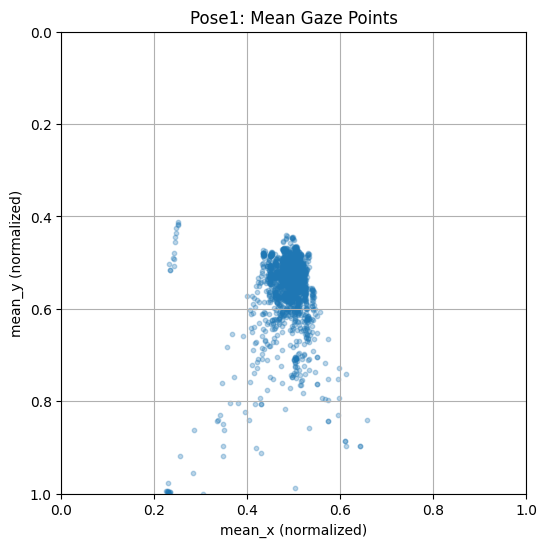

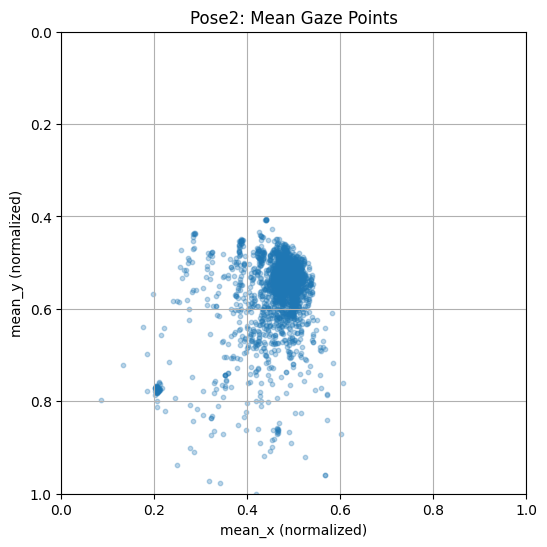

In [341]:
import matplotlib.pyplot as plt



# プロット
plt.figure(figsize=(6, 6))
plt.scatter(pose1_df["mean_x"], pose1_df["mean_y"], alpha=0.3, s=10)
plt.title("Pose1: Mean Gaze Points")
plt.xlabel("mean_x (normalized)")
plt.ylabel("mean_y (normalized)")
plt.xlim(0, 1)
plt.ylim(1, 0)  # Y軸を画面の上から下に反転
plt.grid(True)
plt.show()

# プロット
plt.figure(figsize=(6, 6))
plt.scatter(pose2_df["mean_x"], pose2_df["mean_y"], alpha=0.3, s=10)
plt.title("Pose2: Mean Gaze Points")
plt.xlabel("mean_x (normalized)")
plt.ylabel("mean_y (normalized)")
plt.xlim(0, 1)
plt.ylim(1, 0)  # Y軸を画面の上から下に反転
plt.grid(True)
plt.show()

